# Romanos NN
Neste notebook vamos treinar uma *Rede Neural* simples para converter números para algarismos romanos.

## Dataset
O dataset é uma tabela contendo **4999** algarismos romanos e seu correspondente em algarismos indo-arábicos.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df = pd.read_csv("romanos.csv", sep="\t")
df.head()

,numero,romano
0,1,I
1,2,II
2,3,III
3,4,IV
4,5,V


In [3]:
df.tail()

,numero,romano
4994,4995,MMMMCMXCV
4995,4996,MMMMCMXCVI
4996,4997,MMMMCMXCVII
4997,4998,MMMMCMXCVIII
4998,4999,MMMMCMXCIX


## Preparação dos dados
O primeiro passo para treinar uma rede neural é a preparação de dados. Vamos criar `encodings` para a entrada e a saída dos dados.

A entrada de dados será uma array contendo o valor de cada número em binário (13 bits).

A saída de dados será uma array de 16 bytes contendo a string de saída (128 bits).

In [4]:
df.loc[df["romano"].apply(len).sort_values(ascending=False).index[0]]

numero                4888
romano    MMMMDCCCLXXXVIII
Name: 4887, dtype: object

In [5]:
def encode_in(row):
    R = [int(x) for x in bin(row)[2:]]
    R = [0] * (13 - len(R)) + R
    return R
    
df["in"] = df["numero"].apply(encode_in)
df.head()

,numero,romano,in
0,1,I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,2,II,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,3,III,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]"
3,4,IV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,5,V,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]"


In [6]:
def decode_in(row):
    return int("".join([str(x) for x in row]), base=2)
    
df["in"].apply(decode_in)
df["in"].apply(decode_in) == df["numero"]
all(df["in"].apply(decode_in) == df["numero"])

True

In [7]:
def encode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    zeros = np.zeros((16, len(numerais))).astype(np.uint8)
    R = list(row)
    R = [numerais.index(letra) for letra in R]
    R += [len(numerais)-1] * (16 - len(R))
    zeros[np.arange(16), R] = 1
    return zeros.flatten()
    
df["out"] = df["romano"].apply(encode_out)
df.head()

,numero,romano,in,out
0,1,I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,II,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,III,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,4,IV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,5,V,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
def decode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    return "".join([numerais[i] for i in row.reshape((16, -1)).argmax(axis=1)]).strip()

df["out"].apply(decode_out)
df["out"].apply(decode_out) == df["romano"]
all(df["out"].apply(decode_out) == df["romano"])

True

Após a preparação dos dados, vamos dividir o dataset em dois conjuntos, o conjunto de treino contendo 80% dos dados e o conjunto de teste contendo 20% dos dados.

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_train = df_train.reset_index().drop(columns="index")
df_test = df_test.reset_index().drop(columns="index")

In [10]:
print("conjunto de treino: {} linhas".format(len(df_train)))
df_train.head()

conjunto de treino: 3999 linhas


,numero,romano,in,out
0,2835,MMDCCCXXXV,"[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,3381,MMMCCCLXXXI,"[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,3942,MMMCMXLII,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,208,CCVIII,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,2800,MMDCCC,"[0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [11]:
print("conjunto de teste: {} linhas".format(len(df_test)))
df_test.head()

conjunto de teste: 1000 linhas


,numero,romano,in,out
0,2056,MMLVI,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,1413,MCDXIII,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,3675,MMMDCLXXV,"[0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,3552,MMMDLII,"[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,4592,MMMMDXCII,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### Importante
- Extrair as características dos dados de entrada e saída.
- Separar os conjuntos de treino e de teste.

## Treinamento

As redes neurais realizam apenas três operações muito simples: 
  - MatMul,
  - Bias Add,
  - ACTIVATE!!!
  
![rede neural](Colored_neural_network.svg)

\begin{align}
\text{MatMul: }& h = W^t\cdotp X \\
\text{Bias Add: }& Z = W^t\cdotp X + b\\
\text{ACTIVATE!: }& A = f(W^t\cdotp X + b)\\
\end{align}

Para treinar uma rede, podemos comparar a saída da rede com a saída esperada e ajustar os pesos da matriz ***W*** e do vetor ***b*** de acordo com os erros. A técnica mais utilizada para isso é o **Backpropagation**.

Além disso, existem *otimizadores* que ajudam a manter a estabilidade do treino, além de diminuir o tempo necessário. Utilizaremos o **Adam** que ajusta alguns hiperparâmetros da rede automaticamente.

![adam](adam.png)

Com os dados prontos, podemos treinar as redes neurais. Vamos começar com uma rede pequena com apenas uma camada oculta:

In [12]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=13))
model.add(Dense(units=128, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
Total params: 9,216
Trainable params: 9,216
Non-trainable params: 0
_________________________________________________________________


A rede neural inicialmente "chuta" qualquer valor para a saída (acurácia ~50%). O texto gerado é aleatório.

In [13]:
def evaluate_model(model):
    res = model.evaluate(np.array(df_test["in"].values.tolist()), np.array(df_test["out"].values.tolist()))
    print("Custo: {}\nAcurácia: {}".format(*res))
evaluate_model(model)

1000/1000 [==============================] - 1s 821us/step
Custo: 0.7123326416015625
Acurácia: 0.4670390625


In [14]:
def make_predictions(model):
    pred = model.predict(np.array(df_test["in"].values.tolist()))
    data = []
    for (_, row), p in zip(df_test.iterrows(), pred):
        _p = decode_out(p)
        data.append({
            "numero": row["numero"],
            "romano": row["romano"],
            "pred": _p,
            "match": row["romano"] == _p
        })
    return pd.DataFrame(data)
def evaluate_algorisms(model):
    df = make_predictions(model)
    print(df["match"].sum(), "acertos")
    return df

df_p0 = evaluate_algorisms(model)
df_p0.head()

0 acertos


,match,numero,pred,romano
0,False,2056,MXI MDMM LDMCVDC,MMLVI
1,False,1413,DXIMDVMC I XVXCC,MCDXIII
2,False,3675,MXICMVMI IMMCDCL,MMMDCLXXV
3,False,3552,MXC L LVILXD CXL,MMMDLII
4,False,4592,MXM VMCXLXC XCC,MMMMDXCII


Treinando o modelo por uma época (todos os ~3999 algarismos) começamos a ver resultados mais coerentes:

In [15]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 3599 samples, validate on 400 samples
Epoch 1/1
3599/3599 [==============================] - 0s 82us/step - loss: 0.3938 - acc: 0.8641 - val_loss: 0.2051 - val_acc: 0.9323


In [16]:
df_p1 = evaluate_algorisms(model)
df_p1.head()

0 acertos


,match,numero,pred,romano
0,False,2056,MMMCCXI,MMLVI
1,False,1413,MMMCXXX,MCDXIII
2,False,3675,MMMCCX,MMMDCLXXV
3,False,3552,MMMCCXX,MMMDLII
4,False,4592,MMMMCXX,MMMMDXCII


#### Underfit!!!
Neste caso, o modelo entende a estrutura geral da saída (não separar os algarismos por exemplo), mas ainda não consegue prever os valores corretamente. Dizemos que esse modelo tem um grande viés, e está em regime de **underfit**.


## Treinando mais épocas
Vamos treinar o mesmo modelo por mais 499 épocas:

In [17]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=499, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.1879 - acc: 0.9335 - val_loss: 0.1777 - val_acc: 0.9370
Epoch 2/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.1710 - acc: 0.9375 - val_loss: 0.1638 - val_acc: 0.9411
Epoch 3/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1606 - acc: 0.9398 - val_loss: 0.1546 - val_acc: 0.9426
Epoch 4/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.1537 - acc: 0.9409 - val_loss: 0.1488 - val_acc: 0.9429
Epoch 5/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1493 - acc: 0.9413 - val_loss: 0.1449 - val_acc: 0.9438
Epoch 6/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1461 - acc: 0.9418 - val_loss: 0.1417 - val_acc: 0.9442
Epoch 7/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.1430 - acc: 0.9426 - val_loss: 0.1389 - val_acc: 0.9449
E

3599/3599 [==============================] - 0s 49us/step - loss: 0.1042 - acc: 0.9565 - val_loss: 0.1042 - val_acc: 0.9569
Epoch 61/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1039 - acc: 0.9566 - val_loss: 0.1040 - val_acc: 0.9570
Epoch 62/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.1036 - acc: 0.9568 - val_loss: 0.1039 - val_acc: 0.9568
Epoch 63/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1034 - acc: 0.9569 - val_loss: 0.1037 - val_acc: 0.9572
Epoch 64/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.1032 - acc: 0.9570 - val_loss: 0.1034 - val_acc: 0.9572
Epoch 65/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.1028 - acc: 0.9573 - val_loss: 0.1036 - val_acc: 0.9568
Epoch 66/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.1026 - acc: 0.9573 - val_loss: 0.1033 - val_acc: 0.9575
Epoch 67/499
3599/3599 [==============================

Epoch 120/499
3599/3599 [==============================] - 0s 48us/step - loss: 0.0924 - acc: 0.9617 - val_loss: 0.0954 - val_acc: 0.9611
Epoch 121/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0923 - acc: 0.9616 - val_loss: 0.0952 - val_acc: 0.9610
Epoch 122/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0922 - acc: 0.9617 - val_loss: 0.0952 - val_acc: 0.9613
Epoch 123/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0921 - acc: 0.9619 - val_loss: 0.0950 - val_acc: 0.9616
Epoch 124/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0919 - acc: 0.9619 - val_loss: 0.0952 - val_acc: 0.9611
Epoch 125/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0918 - acc: 0.9619 - val_loss: 0.0950 - val_acc: 0.9613
Epoch 126/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0916 - acc: 0.9620 - val_loss: 0.0948 - val_acc: 0.9613
Epoch 127/499
3599/3599 [=========

3599/3599 [==============================] - 0s 49us/step - loss: 0.0858 - acc: 0.9642 - val_loss: 0.0900 - val_acc: 0.9631
Epoch 180/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0857 - acc: 0.9644 - val_loss: 0.0900 - val_acc: 0.9630
Epoch 181/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0856 - acc: 0.9644 - val_loss: 0.0900 - val_acc: 0.9630
Epoch 182/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0855 - acc: 0.9644 - val_loss: 0.0901 - val_acc: 0.9633
Epoch 183/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0854 - acc: 0.9644 - val_loss: 0.0897 - val_acc: 0.9635
Epoch 184/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0854 - acc: 0.9645 - val_loss: 0.0900 - val_acc: 0.9632
Epoch 185/499
3599/3599 [==============================] - 0s 48us/step - loss: 0.0852 - acc: 0.9644 - val_loss: 0.0894 - val_acc: 0.9637
Epoch 186/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 50us/step - loss: 0.0808 - acc: 0.9662 - val_loss: 0.0856 - val_acc: 0.9655
Epoch 239/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0807 - acc: 0.9665 - val_loss: 0.0860 - val_acc: 0.9648
Epoch 240/499
3599/3599 [==============================] - 0s 48us/step - loss: 0.0806 - acc: 0.9664 - val_loss: 0.0858 - val_acc: 0.9651
Epoch 241/499
3599/3599 [==============================] - 0s 48us/step - loss: 0.0805 - acc: 0.9666 - val_loss: 0.0858 - val_acc: 0.9653
Epoch 242/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0805 - acc: 0.9665 - val_loss: 0.0855 - val_acc: 0.9653
Epoch 243/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0803 - acc: 0.9666 - val_loss: 0.0857 - val_acc: 0.9653
Epoch 244/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0803 - acc: 0.9665 - val_loss: 0.0856 - val_acc: 0.9655
Epoch 245/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 67us/step - loss: 0.0770 - acc: 0.9679 - val_loss: 0.0823 - val_acc: 0.9668
Epoch 298/499
3599/3599 [==============================] - 0s 58us/step - loss: 0.0770 - acc: 0.9680 - val_loss: 0.0823 - val_acc: 0.9666
Epoch 299/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0769 - acc: 0.9681 - val_loss: 0.0824 - val_acc: 0.9666
Epoch 300/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0769 - acc: 0.9679 - val_loss: 0.0822 - val_acc: 0.9668
Epoch 301/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0769 - acc: 0.9680 - val_loss: 0.0824 - val_acc: 0.9668
Epoch 302/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0768 - acc: 0.9680 - val_loss: 0.0825 - val_acc: 0.9667
Epoch 303/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0768 - acc: 0.9680 - val_loss: 0.0822 - val_acc: 0.9666
Epoch 304/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 51us/step - loss: 0.0746 - acc: 0.9689 - val_loss: 0.0803 - val_acc: 0.9673
Epoch 357/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0745 - acc: 0.9690 - val_loss: 0.0804 - val_acc: 0.9672
Epoch 358/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0745 - acc: 0.9689 - val_loss: 0.0801 - val_acc: 0.9672
Epoch 359/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0745 - acc: 0.9689 - val_loss: 0.0805 - val_acc: 0.9671
Epoch 360/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0744 - acc: 0.9689 - val_loss: 0.0803 - val_acc: 0.9672
Epoch 361/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0744 - acc: 0.9690 - val_loss: 0.0801 - val_acc: 0.9672
Epoch 362/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0744 - acc: 0.9690 - val_loss: 0.0805 - val_acc: 0.9673
Epoch 363/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 49us/step - loss: 0.0727 - acc: 0.9696 - val_loss: 0.0787 - val_acc: 0.9679
Epoch 416/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0726 - acc: 0.9696 - val_loss: 0.0794 - val_acc: 0.9672
Epoch 417/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0727 - acc: 0.9696 - val_loss: 0.0790 - val_acc: 0.9674
Epoch 418/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0727 - acc: 0.9697 - val_loss: 0.0785 - val_acc: 0.9679
Epoch 419/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0727 - acc: 0.9696 - val_loss: 0.0788 - val_acc: 0.9680
Epoch 420/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0726 - acc: 0.9697 - val_loss: 0.0787 - val_acc: 0.9677
Epoch 421/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0725 - acc: 0.9698 - val_loss: 0.0786 - val_acc: 0.9678
Epoch 422/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 50us/step - loss: 0.0713 - acc: 0.9701 - val_loss: 0.0778 - val_acc: 0.9679
Epoch 475/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0713 - acc: 0.9701 - val_loss: 0.0775 - val_acc: 0.9683
Epoch 476/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0712 - acc: 0.9701 - val_loss: 0.0772 - val_acc: 0.9684
Epoch 477/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0713 - acc: 0.9700 - val_loss: 0.0774 - val_acc: 0.9683
Epoch 478/499
3599/3599 [==============================] - 0s 50us/step - loss: 0.0712 - acc: 0.9701 - val_loss: 0.0775 - val_acc: 0.9678
Epoch 479/499
3599/3599 [==============================] - 0s 51us/step - loss: 0.0712 - acc: 0.9701 - val_loss: 0.0774 - val_acc: 0.9681
Epoch 480/499
3599/3599 [==============================] - 0s 49us/step - loss: 0.0712 - acc: 0.9702 - val_loss: 0.0772 - val_acc: 0.9680
Epoch 481/499
3599/3599 [=======================

In [18]:
evaluate_model(model)

1000/1000 [==============================] - 0s 17us/step
Custo: 0.07859898394346237
Acurácia: 0.9670546875


In [19]:
df_p500 = evaluate_algorisms(model)
df_p500.head()

39 acertos


,match,numero,pred,romano
0,False,2056,MMLLII,MMLVI
1,False,1413,MCDXX,MCDXIII
2,False,3675,MMMDCLXXI,MMMDCLXXV
3,False,3552,MMMDLXI,MMMDLII
4,False,4592,MMMMDXXX,MMMMDXCII


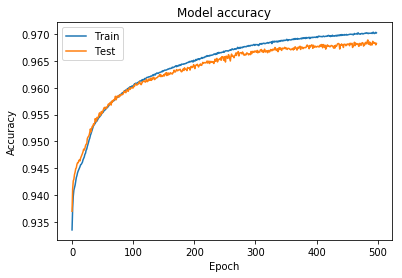

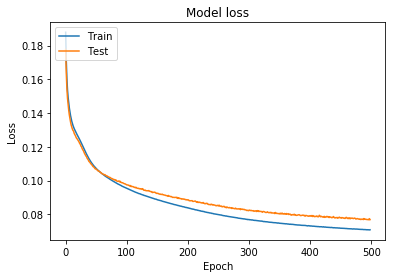

In [20]:
def plot_model(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plot_model(history)

Treinando por mais épocas, conseguimos um modelo que entende o conceito dos algarismo, mas consegue acertar apenas 4% deles. Esse parece ser o limite dessa arquitetura.

## Segunda Tentativa
Como um modelo pequeno não foi capaz de generalizar o problema, vamos criar um modelo mais profundo (10 camadas ocultas):

In [21]:
model2 = Sequential()
model2.add(Dense(units=128, activation='relu', input_dim=13))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [22]:
evaluate_model(model2)

1000/1000 [==============================] - 0s 123us/step
Custo: 0.6929626350402832
Acurácia: 0.519421875


In [23]:
df2_p0 = evaluate_algorisms(model2)
df2_p0.head()

0 acertos


,match,numero,pred,romano
0,False,2056,VC XVMLVD DICD M,MMLVI
1,False,1413,DC XVDDVMIMIVD M,MCDXIII
2,False,3675,VC XIDLVL DIXD M,MMMDCLXXV
3,False,3552,DCCXLDDMLIDVVC M,MMMDLII
4,False,4592,DCCXIDDVDIMDVD M,MMMMDXCII


In [24]:
history2 = model2.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=500, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/500
3599/3599 [==============================] - 1s 198us/step - loss: 0.2464 - acc: 0.9022 - val_loss: 0.1871 - val_acc: 0.9295
Epoch 2/500
3599/3599 [==============================] - 0s 106us/step - loss: 0.1848 - acc: 0.9294 - val_loss: 0.1782 - val_acc: 0.9344
Epoch 3/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.1538 - acc: 0.9377 - val_loss: 0.1387 - val_acc: 0.9415
Epoch 4/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.1380 - acc: 0.9409 - val_loss: 0.1318 - val_acc: 0.9426
Epoch 5/500
3599/3599 [==============================] - 0s 104us/step - loss: 0.1323 - acc: 0.9426 - val_loss: 0.1277 - val_acc: 0.9443
Epoch 6/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.1275 - acc: 0.9456 - val_loss: 0.1210 - val_acc: 0.9484
Epoch 7/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.1195 - acc: 0.9491 - val_loss: 0.1123 - val_acc: 0

3599/3599 [==============================] - 0s 103us/step - loss: 0.0514 - acc: 0.9763 - val_loss: 0.0648 - val_acc: 0.9712
Epoch 61/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0512 - acc: 0.9764 - val_loss: 0.0709 - val_acc: 0.9694
Epoch 62/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0517 - acc: 0.9764 - val_loss: 0.0678 - val_acc: 0.9707
Epoch 63/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0508 - acc: 0.9766 - val_loss: 0.0643 - val_acc: 0.9722
Epoch 64/500
3599/3599 [==============================] - ETA: 0s - loss: 0.0494 - acc: 0.977 - 0s 100us/step - loss: 0.0496 - acc: 0.9770 - val_loss: 0.0651 - val_acc: 0.9716
Epoch 65/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0543 - acc: 0.9752 - val_loss: 0.0682 - val_acc: 0.9697
Epoch 66/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0516 - acc: 0.9763 - val_loss: 0.0665 - val_acc: 0.9711
Epoch 67/

3599/3599 [==============================] - 0s 128us/step - loss: 0.0406 - acc: 0.9810 - val_loss: 0.0679 - val_acc: 0.9727
Epoch 120/500
3599/3599 [==============================] - 0s 100us/step - loss: 0.0401 - acc: 0.9811 - val_loss: 0.0681 - val_acc: 0.9729
Epoch 121/500
3599/3599 [==============================] - 0s 114us/step - loss: 0.0404 - acc: 0.9809 - val_loss: 0.0714 - val_acc: 0.9721
Epoch 122/500
3599/3599 [==============================] - 0s 117us/step - loss: 0.0421 - acc: 0.9803 - val_loss: 0.0727 - val_acc: 0.9722
Epoch 123/500
3599/3599 [==============================] - 0s 121us/step - loss: 0.0436 - acc: 0.9795 - val_loss: 0.0704 - val_acc: 0.9711
Epoch 124/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0414 - acc: 0.9807 - val_loss: 0.0695 - val_acc: 0.9715
Epoch 125/500
3599/3599 [==============================] - 1s 148us/step - loss: 0.0417 - acc: 0.9806 - val_loss: 0.0699 - val_acc: 0.9723
Epoch 126/500
3599/3599 [================

3599/3599 [==============================] - 0s 102us/step - loss: 0.0340 - acc: 0.9847 - val_loss: 0.0820 - val_acc: 0.9705
Epoch 179/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0346 - acc: 0.9846 - val_loss: 0.0799 - val_acc: 0.9715
Epoch 180/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0316 - acc: 0.9859 - val_loss: 0.0864 - val_acc: 0.9708
Epoch 181/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0329 - acc: 0.9853 - val_loss: 0.0857 - val_acc: 0.9712
Epoch 182/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0326 - acc: 0.9855 - val_loss: 0.0880 - val_acc: 0.9708
Epoch 183/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0366 - acc: 0.9838 - val_loss: 0.0811 - val_acc: 0.9709
Epoch 184/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0319 - acc: 0.9858 - val_loss: 0.0876 - val_acc: 0.9700
Epoch 185/500
3599/3599 [================

3599/3599 [==============================] - 0s 102us/step - loss: 0.0244 - acc: 0.9895 - val_loss: 0.1100 - val_acc: 0.9695
Epoch 238/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0233 - acc: 0.9900 - val_loss: 0.1120 - val_acc: 0.9703
Epoch 239/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0228 - acc: 0.9902 - val_loss: 0.1168 - val_acc: 0.9691
Epoch 240/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0257 - acc: 0.9892 - val_loss: 0.1071 - val_acc: 0.9700
Epoch 241/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0231 - acc: 0.9901 - val_loss: 0.1113 - val_acc: 0.9704
Epoch 242/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0229 - acc: 0.9902 - val_loss: 0.1184 - val_acc: 0.9696
Epoch 243/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0243 - acc: 0.9896 - val_loss: 0.1165 - val_acc: 0.9692
Epoch 244/500
3599/3599 [================

3599/3599 [==============================] - 0s 102us/step - loss: 0.0193 - acc: 0.9920 - val_loss: 0.1295 - val_acc: 0.9711
Epoch 297/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0155 - acc: 0.9935 - val_loss: 0.1349 - val_acc: 0.9709
Epoch 298/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0119 - acc: 0.9952 - val_loss: 0.1483 - val_acc: 0.9704
Epoch 299/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0108 - acc: 0.9956 - val_loss: 0.1518 - val_acc: 0.9713
Epoch 300/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0113 - acc: 0.9954 - val_loss: 0.1618 - val_acc: 0.9692
Epoch 301/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0176 - acc: 0.9929 - val_loss: 0.1519 - val_acc: 0.9696
Epoch 302/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0254 - acc: 0.9899 - val_loss: 0.1335 - val_acc: 0.9691
Epoch 303/500
3599/3599 [================

3599/3599 [==============================] - 0s 102us/step - loss: 0.0172 - acc: 0.9933 - val_loss: 0.1576 - val_acc: 0.9684
Epoch 356/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0141 - acc: 0.9945 - val_loss: 0.1626 - val_acc: 0.9701
Epoch 357/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0102 - acc: 0.9961 - val_loss: 0.1733 - val_acc: 0.9698
Epoch 358/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0092 - acc: 0.9964 - val_loss: 0.1792 - val_acc: 0.9697
Epoch 359/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0085 - acc: 0.9967 - val_loss: 0.1836 - val_acc: 0.9701
Epoch 360/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0093 - acc: 0.9964 - val_loss: 0.1900 - val_acc: 0.9695
Epoch 361/500
3599/3599 [==============================] - 0s 100us/step - loss: 0.0209 - acc: 0.9926 - val_loss: 0.1710 - val_acc: 0.9667
Epoch 362/500
3599/3599 [================

3599/3599 [==============================] - 0s 102us/step - loss: 0.0108 - acc: 0.9960 - val_loss: 0.2007 - val_acc: 0.9685
Epoch 415/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0145 - acc: 0.9948 - val_loss: 0.1932 - val_acc: 0.9690
Epoch 416/500
3599/3599 [==============================] - 0s 106us/step - loss: 0.0173 - acc: 0.9937 - val_loss: 0.1768 - val_acc: 0.9681
Epoch 417/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0130 - acc: 0.9951 - val_loss: 0.1827 - val_acc: 0.9681
Epoch 418/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0099 - acc: 0.9963 - val_loss: 0.1848 - val_acc: 0.9695
Epoch 419/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0129 - acc: 0.9953 - val_loss: 0.1897 - val_acc: 0.9690
Epoch 420/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0122 - acc: 0.9955 - val_loss: 0.1880 - val_acc: 0.9691
Epoch 421/500
3599/3599 [================

3599/3599 [==============================] - 0s 102us/step - loss: 0.0258 - acc: 0.9906 - val_loss: 0.1606 - val_acc: 0.9676
Epoch 474/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0123 - acc: 0.9956 - val_loss: 0.1676 - val_acc: 0.9687
Epoch 475/500
3599/3599 [==============================] - 0s 102us/step - loss: 0.0071 - acc: 0.9976 - val_loss: 0.1853 - val_acc: 0.9688
Epoch 476/500
3599/3599 [==============================] - 0s 103us/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.2005 - val_acc: 0.9694
Epoch 477/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.2159 - val_acc: 0.9694
Epoch 478/500
3599/3599 [==============================] - 0s 101us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.2244 - val_acc: 0.9699
Epoch 479/500
3599/3599 [==============================] - 0s 100us/step - loss: 9.8124e-04 - acc: 0.9999 - val_loss: 0.2351 - val_acc: 0.9697
Epoch 480/500
3599/3599 [============

In [25]:
evaluate_model(model2)

1000/1000 [==============================] - 0s 23us/step
Custo: 0.2148492760658264
Acurácia: 0.96878125


In [26]:
df2_p500 = evaluate_algorisms(model2)
df2_p500.head()

49 acertos


,match,numero,pred,romano
0,False,2056,MMCIV,MMLVI
1,False,1413,MCDXV,MCDXIII
2,False,3675,MMMDCLXXII,MMMDCLXXV
3,False,3552,MMMDLVI,MMMDLII
4,False,4592,MMMMDXCVIII,MMMMDXCII


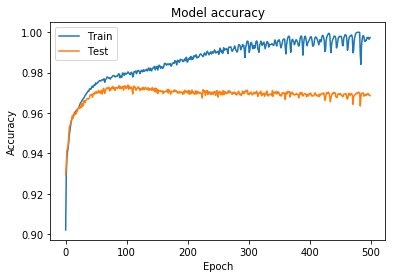

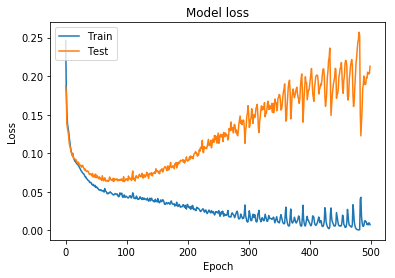

In [27]:
plot_model(history2)

#### Overfit!!
Dessa vez o modelo consegue acertar todo o conjunto de treino mas não o conjunto de testes, o modelo apenas decorou os algarismos do conjunto de treino mas não consegue generalizar o problema. Dizemos que esse modelo possui uma grande variância e está em regime de **overfit**.

## Terceira tentativa
Por último, vamos tentar uma rede com 4 camadas ocultas, mas com mais nós em cada camada para extrair mais características.

In [28]:
model3 = Sequential()
model3.add(Dense(units=1024, activation='relu', input_dim=13))
model3.add(Dense(units=512, activation='relu'))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=128, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              14336     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
Total params: 703,360
Trainable params: 703,360
Non-trainable params: 0
_________________________________________________________________


In [29]:
history3 = model3.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=120, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/120
3599/3599 [==============================] - 1s 177us/step - loss: 0.2074 - acc: 0.9223 - val_loss: 0.1404 - val_acc: 0.9423
Epoch 2/120
3599/3599 [==============================] - 0s 91us/step - loss: 0.1340 - acc: 0.9449 - val_loss: 0.1244 - val_acc: 0.9507
Epoch 3/120
3599/3599 [==============================] - 0s 93us/step - loss: 0.1202 - acc: 0.9509 - val_loss: 0.1132 - val_acc: 0.9532
Epoch 4/120
3599/3599 [==============================] - 0s 90us/step - loss: 0.1097 - acc: 0.9544 - val_loss: 0.1041 - val_acc: 0.9558
Epoch 5/120
3599/3599 [==============================] - 0s 92us/step - loss: 0.1032 - acc: 0.9565 - val_loss: 0.1000 - val_acc: 0.9582
Epoch 6/120
3599/3599 [==============================] - 0s 91us/step - loss: 0.0989 - acc: 0.9583 - val_loss: 0.0956 - val_acc: 0.9602
Epoch 7/120
3599/3599 [==============================] - 0s 94us/step - loss: 0.0945 - acc: 0.9603 - val_loss: 0.0946 - val_acc: 0.9599


3599/3599 [==============================] - 0s 91us/step - loss: 0.0135 - acc: 0.9949 - val_loss: 0.0449 - val_acc: 0.9839
Epoch 61/120
3599/3599 [==============================] - 0s 91us/step - loss: 0.0123 - acc: 0.9955 - val_loss: 0.0454 - val_acc: 0.9848
Epoch 62/120
3599/3599 [==============================] - 0s 91us/step - loss: 0.0114 - acc: 0.9959 - val_loss: 0.0448 - val_acc: 0.9852
Epoch 63/120
3599/3599 [==============================] - 0s 88us/step - loss: 0.0121 - acc: 0.9955 - val_loss: 0.0453 - val_acc: 0.9853
Epoch 64/120
3599/3599 [==============================] - 0s 89us/step - loss: 0.0120 - acc: 0.9955 - val_loss: 0.0478 - val_acc: 0.9838
Epoch 65/120
3599/3599 [==============================] - 0s 91us/step - loss: 0.0114 - acc: 0.9957 - val_loss: 0.0442 - val_acc: 0.9854
Epoch 66/120
3599/3599 [==============================] - 0s 90us/step - loss: 0.0108 - acc: 0.9960 - val_loss: 0.0490 - val_acc: 0.9844
Epoch 67/120
3599/3599 [==============================

3599/3599 [==============================] - 0s 91us/step - loss: 2.7579e-04 - acc: 1.0000 - val_loss: 0.0645 - val_acc: 0.9864
Epoch 120/120
3599/3599 [==============================] - 0s 92us/step - loss: 2.5556e-04 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9860


In [30]:
evaluate_model(model3)

1000/1000 [==============================] - 0s 18us/step
Custo: 0.06182693022489548
Acurácia: 0.9866484375


In [31]:
df3_p120 = evaluate_algorisms(model3)
df3_p120.head()

453 acertos


,match,numero,pred,romano
0,True,2056,MMLVI,MMLVI
1,True,1413,MCDXIII,MCDXIII
2,True,3675,MMMDCLXXV,MMMDCLXXV
3,True,3552,MMMDLII,MMMDLII
4,False,4592,MMMMDXCIII,MMMMDXCII


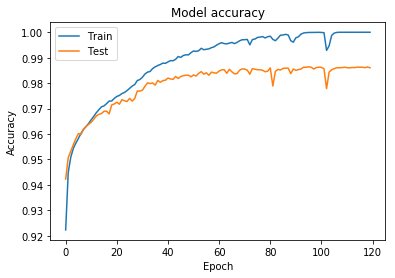

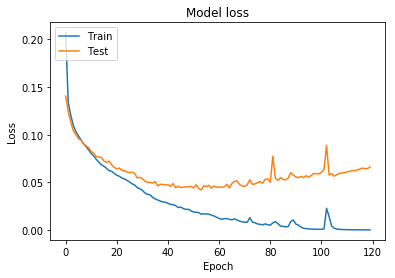

In [32]:
plot_model(history3)

#### Certin!!!
Encontrar os parâmetros ótimos para cada problema é um processo iterativo e requer paciência e experiência.

## Importante
- Cada "neurônio" é muito simples (MatMul, Bias Add, ACTIVATE!),
- Backpropagation,
- Escolha da arquitetura e hiperparâmetros (camadas, ativações, otimizador),
- **Escolha do custo**,
- RNNs provavelmente conseguem 100% nesse dataset,
### - ML IS FUN KIDS!

In [33]:
def predict(n):
    n_enc = encode_in(n)
    print("encode n: {}".format(n_enc))
    pred = model3.predict(np.array([n_enc]))
    print("pred enc_n: {}".format(pred.round(3).reshape((16, -1))))
    out = decode_out(pred)
    print("decode pred: {}".format(out))
    return out
predict(666)

encode n: [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
pred enc_n: [[0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.995 0.    0.    0.    0.    0.    0.   ]
 [0.997 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.007 0.    0.    0.    0.    0.    0.998]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]
decode pred: DCLXVI


'DCLXVI'